# Patch smoothing

In this example, we will show how to use the patch smoothing algorithm to smooth a 3D pointcloud on the surface of an object with spherical geometry, such as an fluorescently labelled droplet in tissue. We use the example data from the napari-stress repository which has been published along with the [original code](https://github.com/campaslab/STRESS).

In [1]:
from napari_stress import reconstruction, frame_by_frame, extract_vertex_points
import napari
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import napari_process_points_and_surfaces as nppas
import numpy as np

In [2]:
viewer = napari.Viewer(ndisplay=3)
viewer.open_sample('napari-stress', 'Droplet image (4D)')

Assistant skips harvesting pyclesperanto as it's not installed.


[<Image layer 'Image' at 0x1e9b3182280>]

## Segmentation

We will first get ourselves an estimation for a pointcloud from a segmented image. We simply binarize all the timesteps with Otsu's threshold and convert it to a surface using [napari-process-points-and-surfaces](https://github.com/haesleinhuepf/napari-process-points-and-surfaces)

In [3]:
transformed = frame_by_frame(nsbatwm.rescale)(viewer.layers[0].data, 1,1, 2)
binary = frame_by_frame(nsbatwm.threshold_otsu)(transformed)
viewer.add_image(transformed, name='transformed')

<Image layer 'transformed' at 0x1e99db2d040>

Once we have the surface, we decimate and smooth it a bit to get a more regular pointcloud of manageable size.

In [4]:
surface = frame_by_frame(nppas.largest_label_to_surface)(binary)
surface_smooth = frame_by_frame(nppas.smooth_surface)(surface)
surface_decimated = frame_by_frame(nppas.decimate_quadric)(surface_smooth, number_of_vertices=256)

We get the pointcloud by simply extracting the coordinates of the surface verticces.

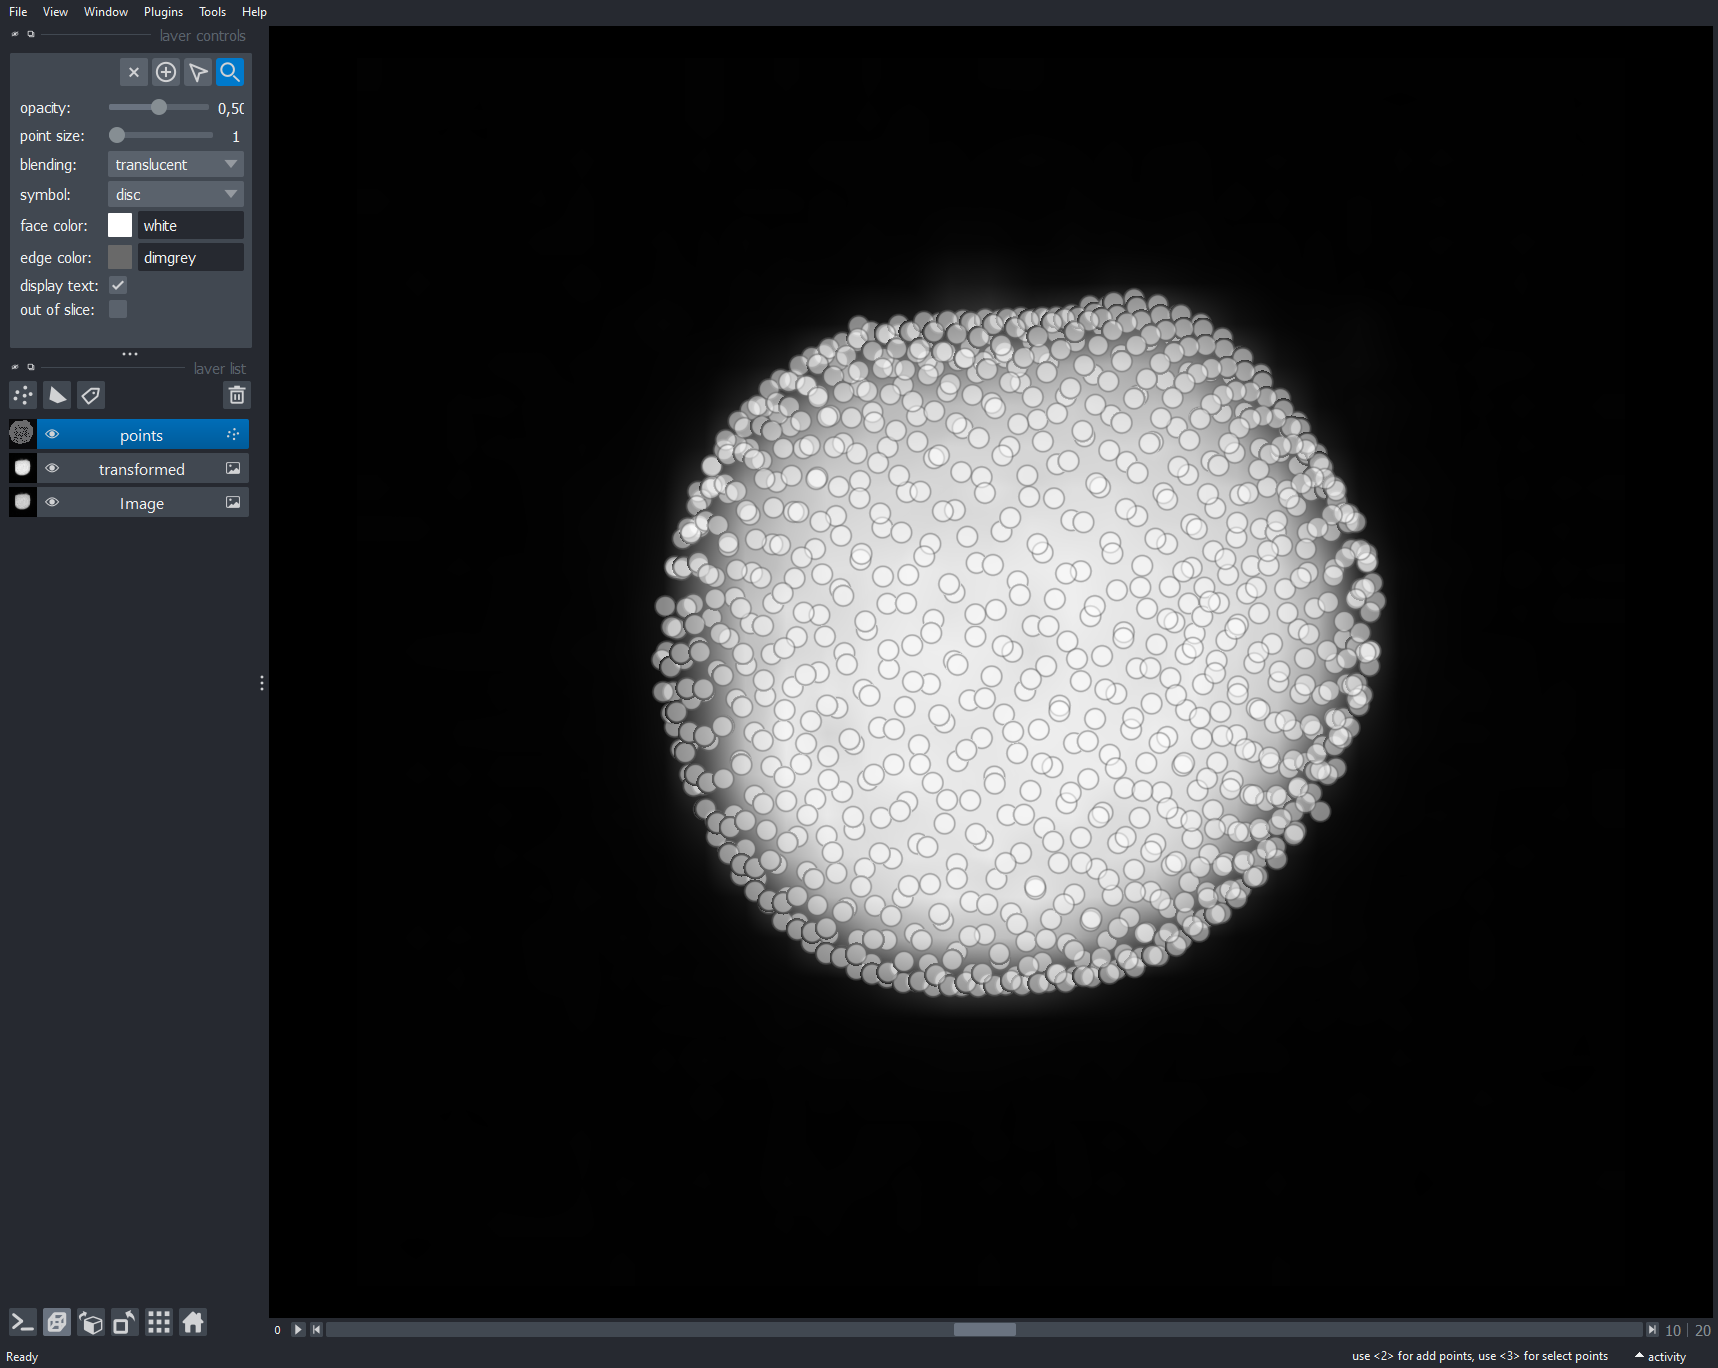

In [5]:
points = frame_by_frame(extract_vertex_points)(surface_decimated)
points_resampled = frame_by_frame(reconstruction.resample_pointcloud)(points, sampling_length=1)
viewer.add_points(points_resampled, name='points', size=0.5, opacity=0.5)
napari.utils.nbscreenshot(viewer)

## Patch fitting

For patch fitting, a local neighborhood around each point is defined using a [kdTree solver](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html). This local neighborhood is transformed into a space with oorigin zero and the major axis of the patch being aligned along the z-axis. A quadratic expression is then fitted to the pointcloud which can be used to approximate the position of each point with respect to the local curvature of the surface. 

To demonstrate it, let's look at the internals:

In [6]:
from napari_stress._reconstruction.patches import (estimate_patch_radii,
                                                   find_neighbor_indices,
                                                   orient_patch,
                                                   fit_quadratic_surface, 
                                                   create_fitted_coordinates,
                                                   compute_orientation_matrix,
                                                   calculate_mean_curvature_on_patch)

Let's extract the current timepoint from the data:

In [7]:
point_cloud = points_resampled[points_resampled[:, 0] == viewer.dims.current_step[0]][:, 1:]

In [8]:
# Initialize fitted point cloud and find neighbors
fitted_point_cloud = np.copy(point_cloud)
search_radii = estimate_patch_radii(point_cloud)
    
neighbor_indices = find_neighbor_indices(point_cloud, search_radii)
mean_curvatures = [np.nan] * len(point_cloud)
principal_curvatures = [np.nan] * len(point_cloud)

# Compute neighbors for each point in the point cloud
for idx in range(len(point_cloud)):
    patch = point_cloud[neighbor_indices[idx], :]

    # Orient the patch for the current point
    oriented_patch, oriented_query_point, _, patch_center, orient_matrix = orient_patch(
        patch, point_cloud[idx, :], np.mean(point_cloud, axis=0))

    # Perform the quadratic surface fitting
    fitting_params = fit_quadratic_surface(oriented_patch)

    # Calculate the new fitted point
    fitted_query_point = create_fitted_coordinates(
        oriented_query_point[None, :], fitting_params)
    fitted_patch = create_fitted_coordinates(oriented_patch, fitting_params)

    # Transform the fitted patch and fitted point back to the original
    fitted_point_cloud[idx, :] = fitted_query_point[None, :] @ orient_matrix.T +\
        patch_center
    fitted_patch_transformed = fitted_patch @ orient_matrix.T + patch_center
    
    mean_curv, principal_curv = calculate_mean_curvature_on_patch(
        fitted_query_point, fitting_params)
    
    mean_curvatures[idx] = mean_curv
    principal_curvatures[idx] = principal_curv

What's happening here? let's break it down: First, the patch is extracted bassed on the neighborhood:

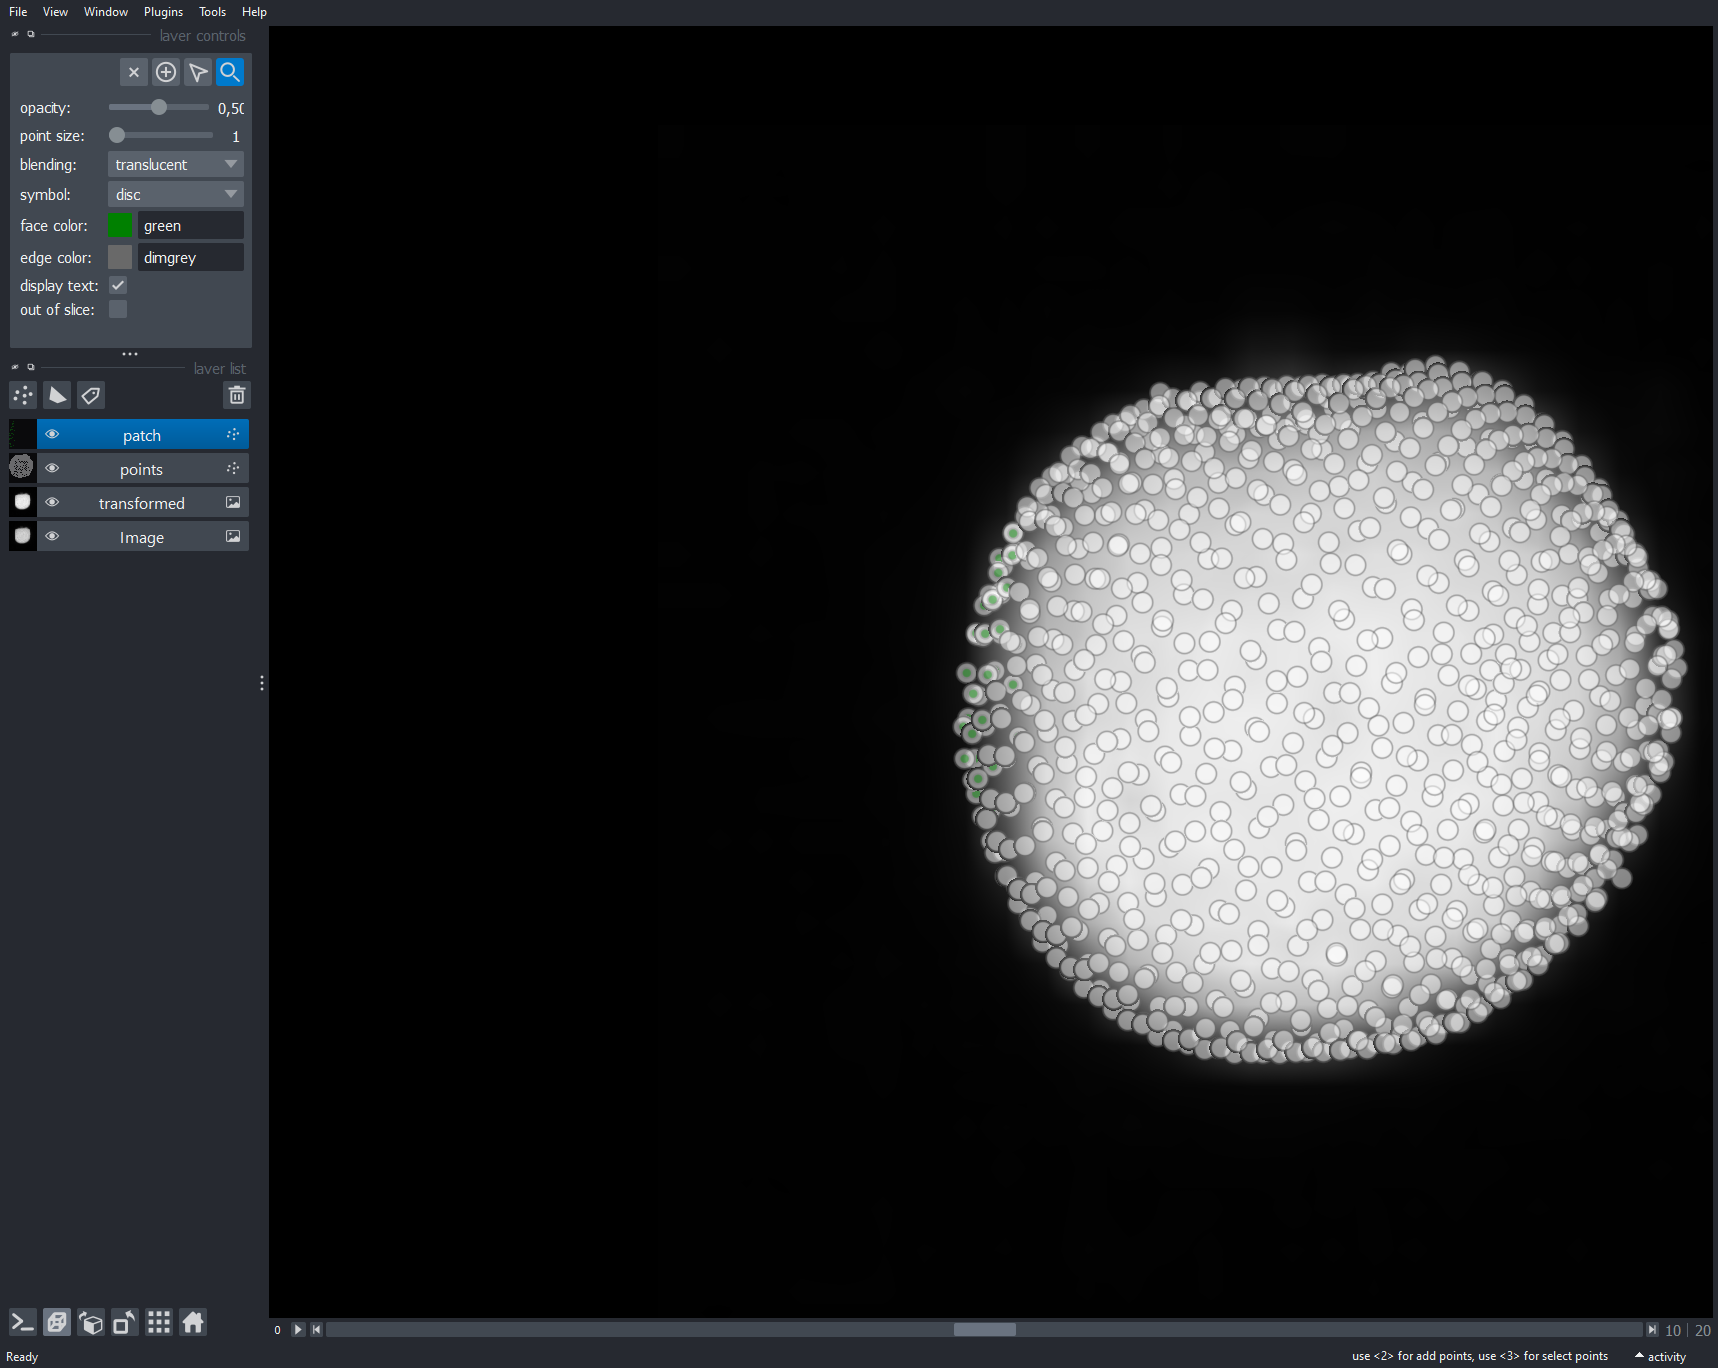

In [9]:
viewer.add_points(patch, size=0.25, opacity=0.5, name='patch',
                    face_color='green')
viewer.camera.center = patch.mean(axis=0)
napari.utils.nbscreenshot(viewer)

These points are then transformed into a coordinate system with origin zero and the major axis of the patch being aligned along the z-axis (red vector for reference). The points (green) are then fitted with a quadratic expression (fitted points in orange).

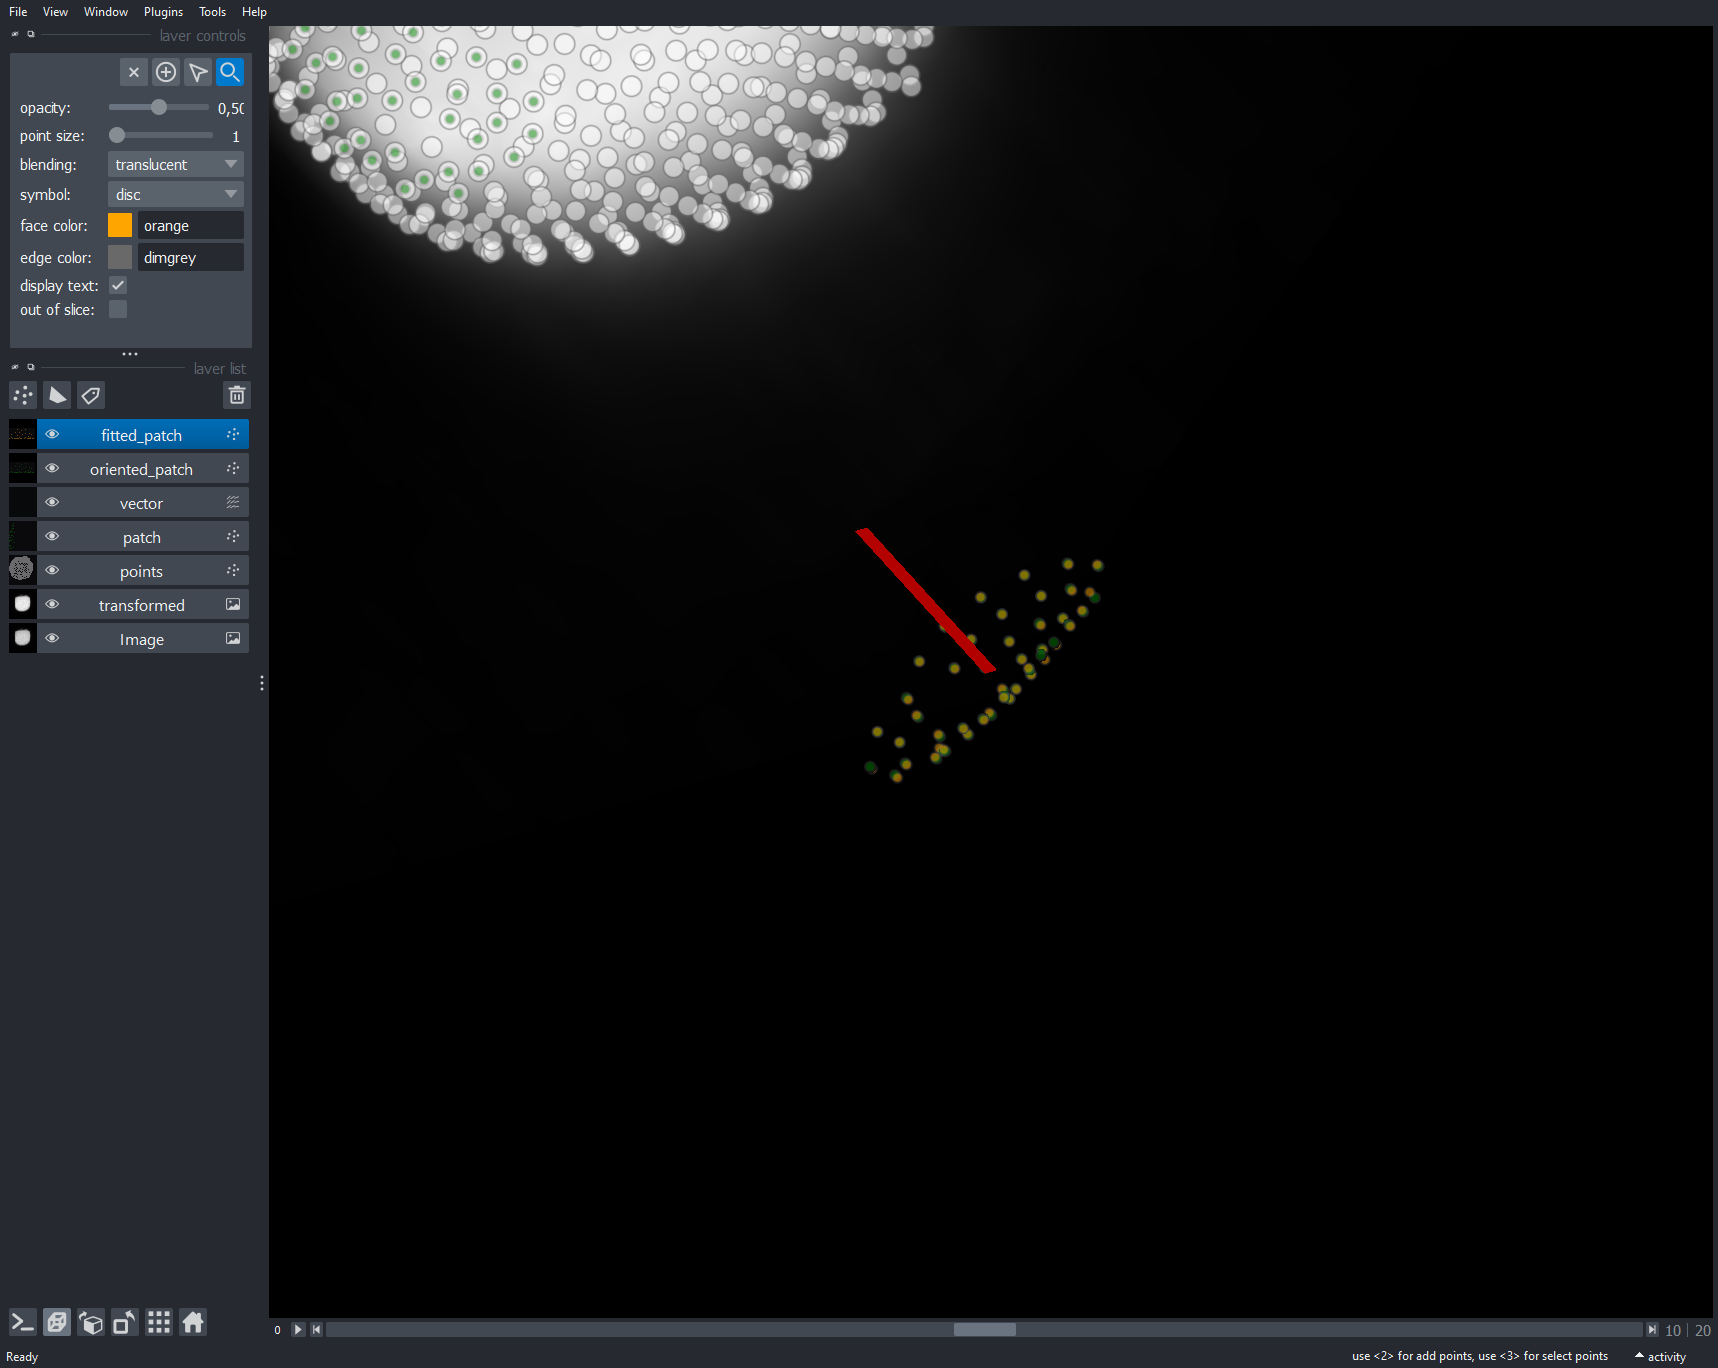

In [10]:
origin = np.array([0, 0, 0])
z = np.array([1, 0, 0])
vector = np.stack([origin, z], axis=0)
viewer.add_vectors(vector, name='vector', edge_width=0.5, length=5)

viewer.add_points(oriented_patch, size=0.25, opacity=0.5, name='oriented_patch',
                    face_color='green')
viewer.add_points(fitted_patch, size=0.25, opacity=0.5, name='fitted_patch',
                    face_color='orange')

viewer.camera.center =  fitted_patch.mean(axis=0)
viewer.camera.angles = (55, -32, -23)
napari.utils.nbscreenshot(viewer)

The points are then transformed back to the original coordinate system and the fitted point around which the neighborhood patch was reconstructed is replaced with the fitted point.

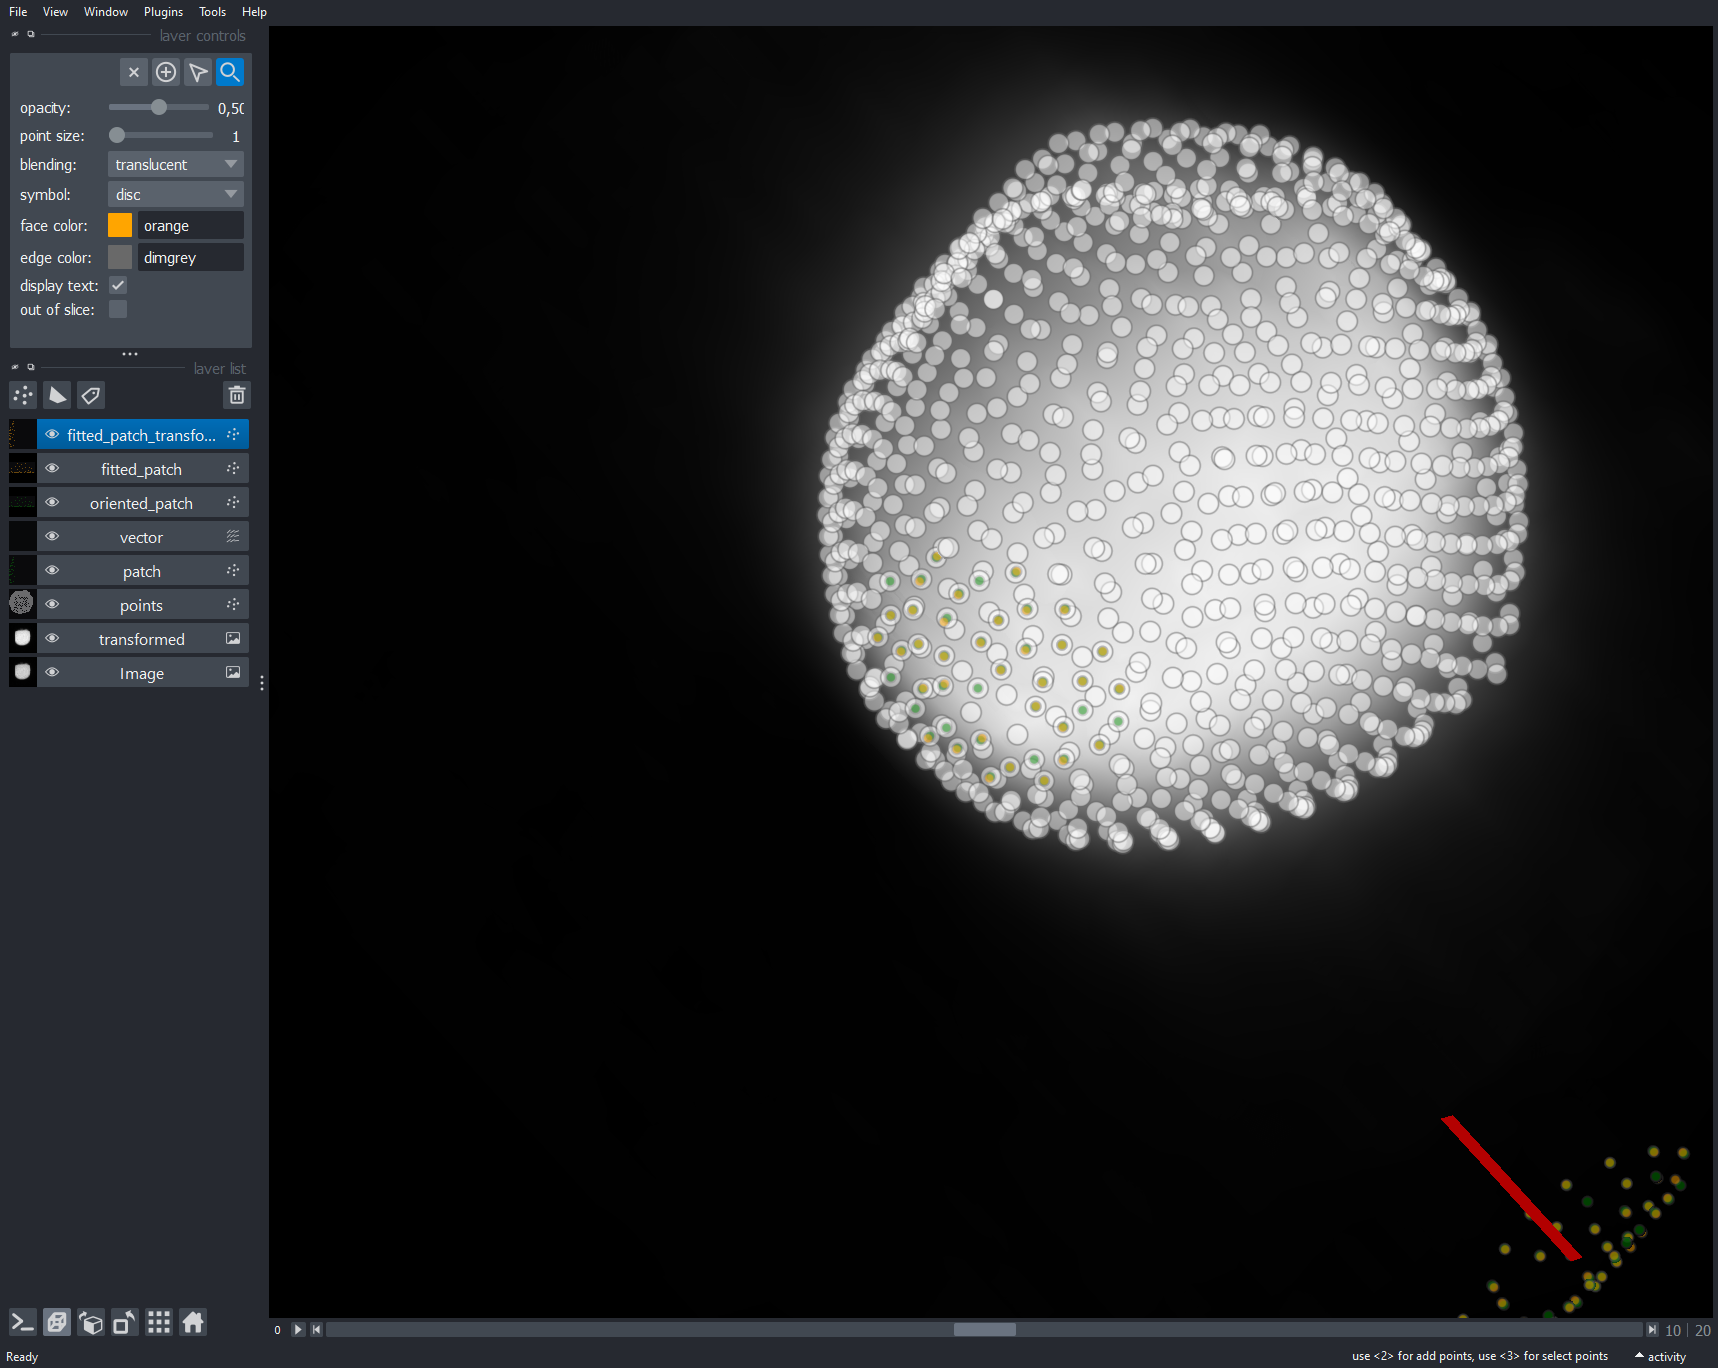

In [11]:
viewer.add_points(fitted_patch_transformed, size=0.25, opacity=0.5, name='fitted_patch_transformed',
                    face_color='orange')
viewer.camera.center =  fitted_patch_transformed.mean(axis=0)
napari.utils.nbscreenshot(viewer)

## Shortcut

This process can be called from a convenience function like this:

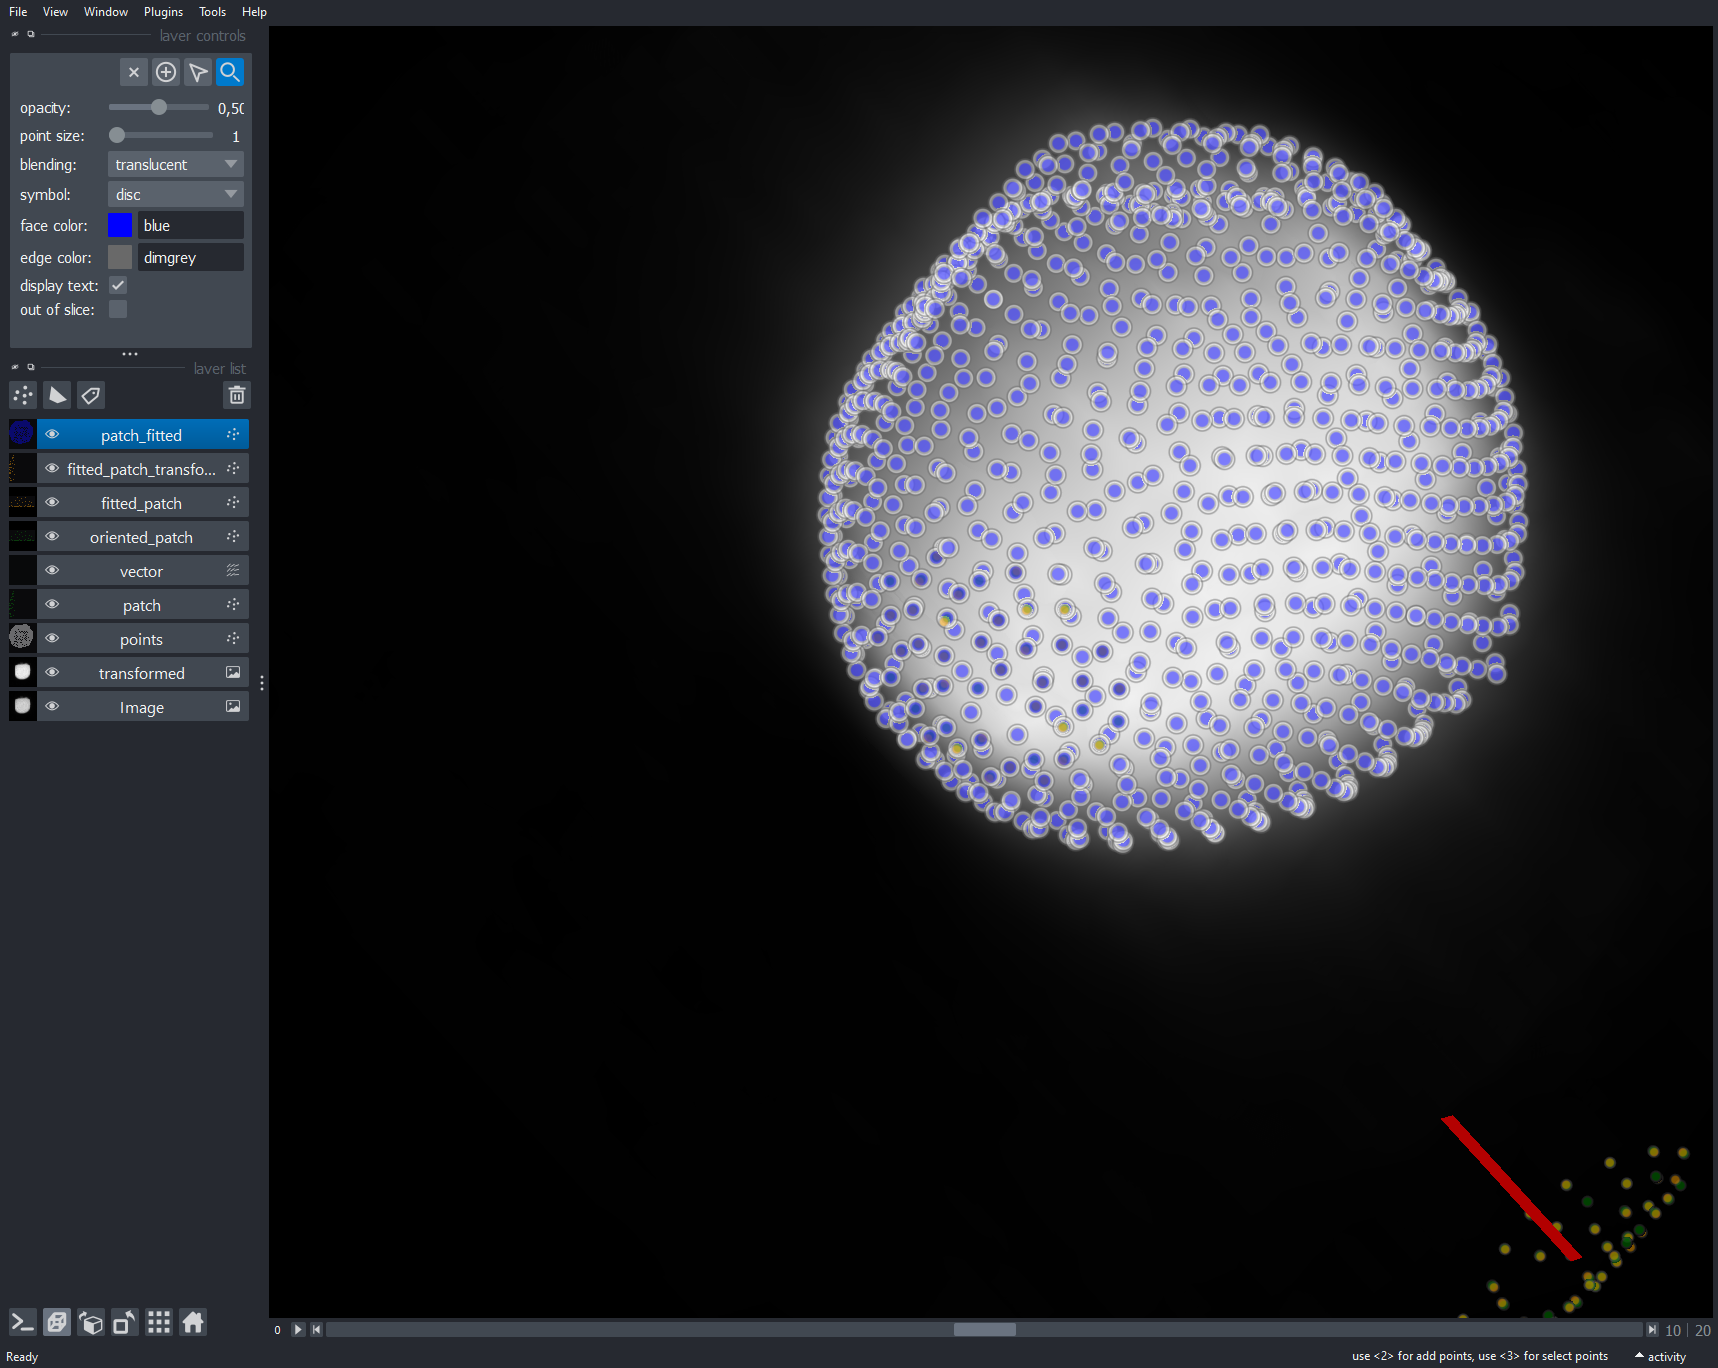

In [12]:
patch_fitted = reconstruction.fit_patches(points_resampled)
viewer.add_points(patch_fitted, size=0.35, opacity=0.5, name='patch_fitted',
                    face_color='blue')
napari.utils.nbscreenshot(viewer)

## Adaptive patch-fitting

Obviously, the radius of the neighborhood is an important parameter to set here - larger radii lead to larger neighborhoods and a stronger representation of global curvature rather than local shape. On the other hand, a radius too small will not allow for a good fit of the local curvature. The adaptive, iterative method offers a tradeoff: Curvature is locally estimated and a corresponding radius is defined. For higher curvature, the neighborhood is smaller than for lower curvature.

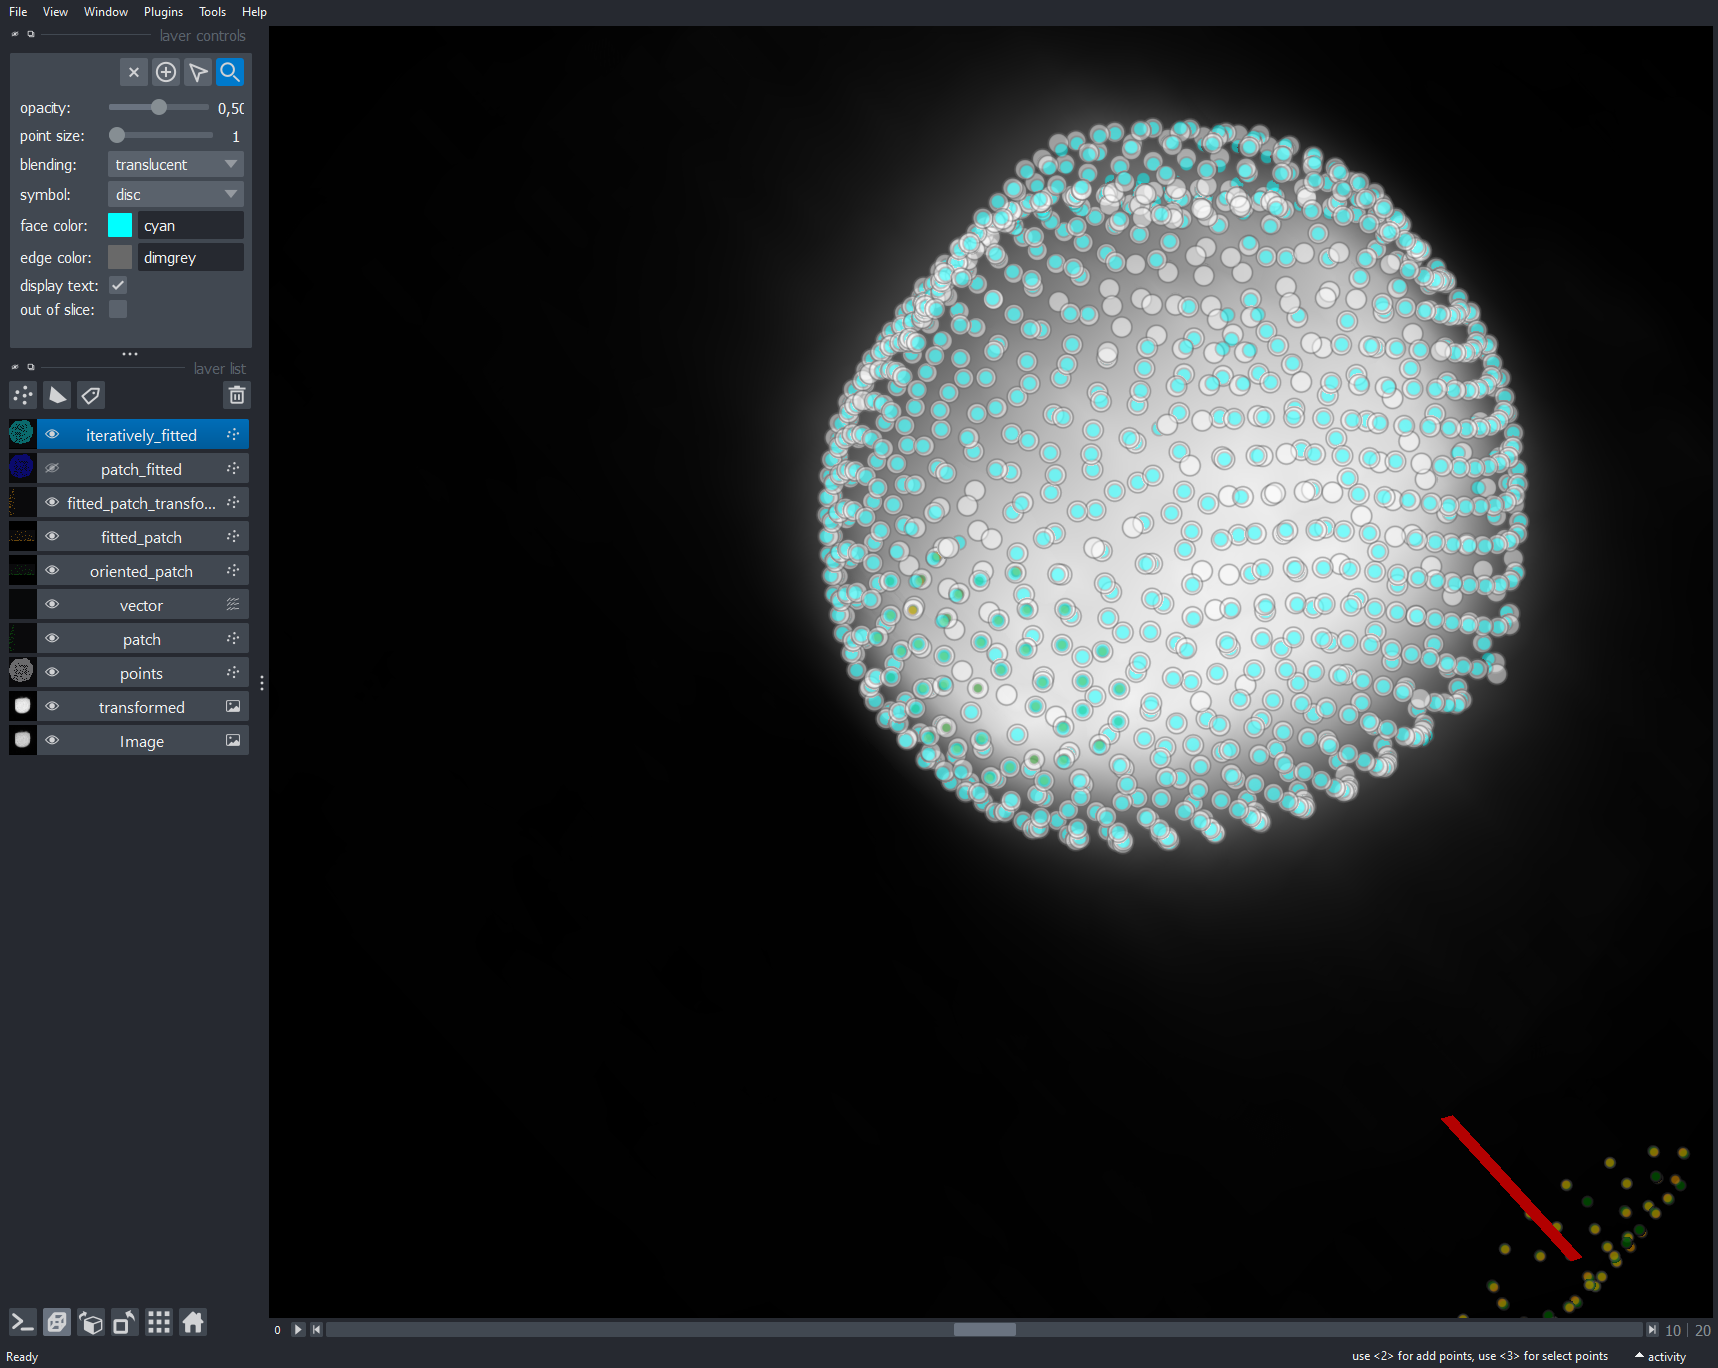

In [14]:
iteratively_fitted = reconstruction.iterative_curvature_adaptive_patch_fitting(points_resampled, n_iterations=2, minimum_neighbors=18)
viewer.add_points(iteratively_fitted, size=0.35, opacity=0.5, name='iteratively_fitted',
                    face_color='cyan')
viewer.layers['patch_fitted'].visible = False
napari.utils.nbscreenshot(viewer)